<a href="https://colab.research.google.com/github/hecshzye/ConvNeXt-Classifier-test-1/blob/main/ConvNeXt_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## TPU/GPU detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
try:  # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:  # detect GPUs
    tpu = False
    strategy = (
        tf.distribute.get_strategy()
    )  # default strategy that works on CPU and single GPU
print("Number of Accelerators: ", strategy.num_replicas_in_sync)

Number of Accelerators:  1


## Configuration

In [4]:
# Model
IMAGE_SIZE = [224, 224]
MODEL_PATH = "https://tfhub.dev/sayakpaul/convnext_tiny_1k_224_fe/1"

# TPU
if tpu:
    BATCH_SIZE = (
        16 * strategy.num_replicas_in_sync
    )  # a TPU has 8 cores so this will be 128
else:
    BATCH_SIZE = 64  # on Colab/GPU, a higher batch size may throw(OOM)

# Dataset
CLASSES = [
    "dandelion",
    "daisy",
    "tulips",
    "sunflowers",
    "roses",
]  # don't change the order

# Other constants
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std
AUTO = tf.data.AUTOTUNE

# Data Pipeline

In [5]:
def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = IMAGE_SIZE):
    def preprocess(image, label):
        # for training, do augmentation
        if train:
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)
        image = tf.image.resize(image, size=image_size, method="bicubic")
        image = (image - MEAN) / STD  # normalization
        return image, label

    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    return dataset.map(preprocess, AUTO).batch(BATCH_SIZE).prefetch(AUTO)

# Flower Dataset

In [6]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers",
    split=["train[:90%]", "train[90%:]"],
    as_supervised=True,
    try_gcs=False,  # gcs_path is necessary for tpu,
)

num_train = tf.data.experimental.cardinality(train_dataset)
num_val = tf.data.experimental.cardinality(val_dataset)
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")


Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of training examples: 3303
Number of validation examples: 367


## Prepare dataset

In [7]:
train_dataset = make_dataset(train_dataset, True)
val_dataset = make_dataset(val_dataset, False)

## Visualize

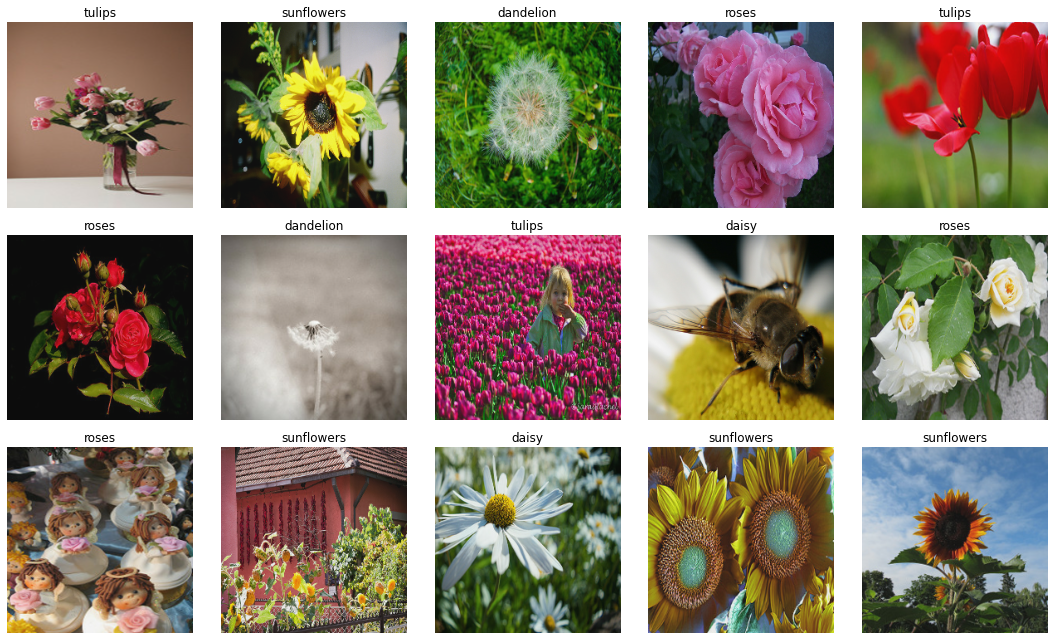

In [8]:
sample_images, sample_labels = next(iter(train_dataset))

plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n] * STD + MEAN).numpy()
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    plt.title(CLASSES[sample_labels[n]])
    plt.axis("off")
plt.tight_layout()
plt.show()


# LR Scheduler Utility

In [9]:
# Reference:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

# Model Utility

In [10]:
def get_model(model_path=MODEL_PATH, res=224, num_classes=5):
    hub_layer = hub.KerasLayer(model_path, trainable=True)

    model = keras.Sequential(
        [
            keras.layers.InputLayer((res, res, 3)),
            hub_layer,
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model

In [11]:
get_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 768)               27820128  
                                                                 
 dense (Dense)               (None, 5)                 3845      
                                                                 
Total params: 27,823,973
Trainable params: 27,823,973
Non-trainable params: 0
_________________________________________________________________


# Training Hyperparameters

In [12]:
EPOCHS = 10
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)

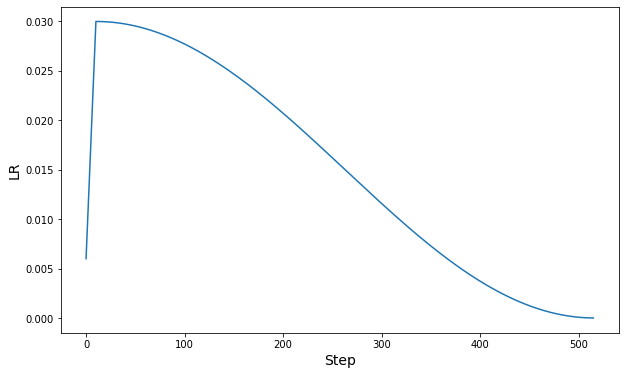

In [13]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()


In [14]:
optimizer = keras.optimizers.SGD(scheduled_lrs)
loss = keras.losses.SparseCategoricalCrossentropy()

# Training & Validation

In [15]:
with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)
  model = get_model(MODEL_PATH)
  model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

Epoch 1/10
52/52 [==============================] - 105s 2s/step - loss: 0.8674 - accuracy: 0.7100 - val_loss: 0.4298 - val_accuracy: 0.8828
Epoch 2/10
52/52 [==============================] - 78s 2s/step - loss: 0.3361 - accuracy: 0.8995 - val_loss: 0.2833 - val_accuracy: 0.9046
Epoch 3/10
52/52 [==============================] - 78s 2s/step - loss: 0.2260 - accuracy: 0.9270 - val_loss: 0.2955 - val_accuracy: 0.8801
Epoch 4/10
52/52 [==============================] - 79s 2s/step - loss: 0.1649 - accuracy: 0.9500 - val_loss: 0.1815 - val_accuracy: 0.9346
Epoch 5/10
52/52 [==============================] - 79s 2s/step - loss: 0.1262 - accuracy: 0.9637 - val_loss: 0.1528 - val_accuracy: 0.9428
Epoch 6/10
52/52 [==============================] - 79s 2s/step - loss: 0.1037 - accuracy: 0.9731 - val_loss: 0.1360 - val_accuracy: 0.9482
Epoch 7/10
52/52 [==============================] - 79s 2s/step - loss: 0.0865 - accuracy: 0.9797 - val_loss: 0.1295 - val_accuracy: 0.9510
Epoch 8/10
52/52 [=

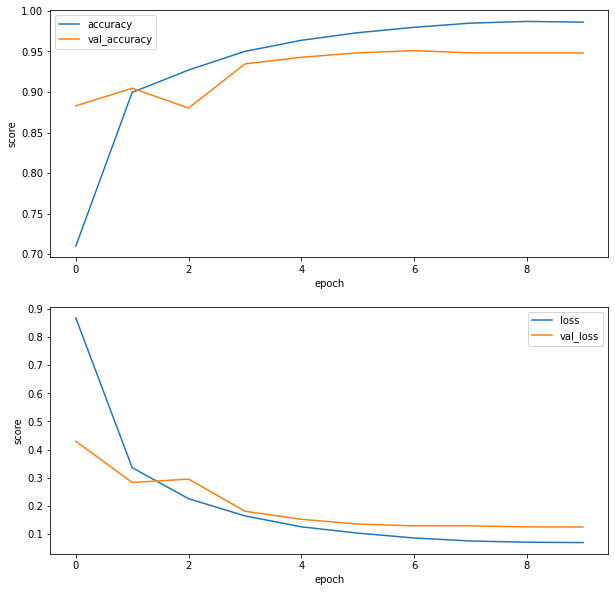

In [16]:
result = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
result[["accuracy", "val_accuracy"]].plot(xlabel="epoch", ylabel="score", ax=ax[0])
result[["loss", "val_loss"]].plot(xlabel="epoch", ylabel="score", ax=ax[1])


# Predictions

In [17]:
sample_images, sample_labels = next(iter(val_dataset))

predictions = model.predict(sample_images, batch_size=16).argmax(axis=-1)
evaluations = model.evaluate(sample_images, sample_labels, batch_size=16)

print("[val_loss, val_acc]", evaluations)

4/4 [==============================] - 1s 127ms/step - loss: 0.1901 - accuracy: 0.8906
[val_loss, val_acc] [0.19013457000255585, 0.890625]


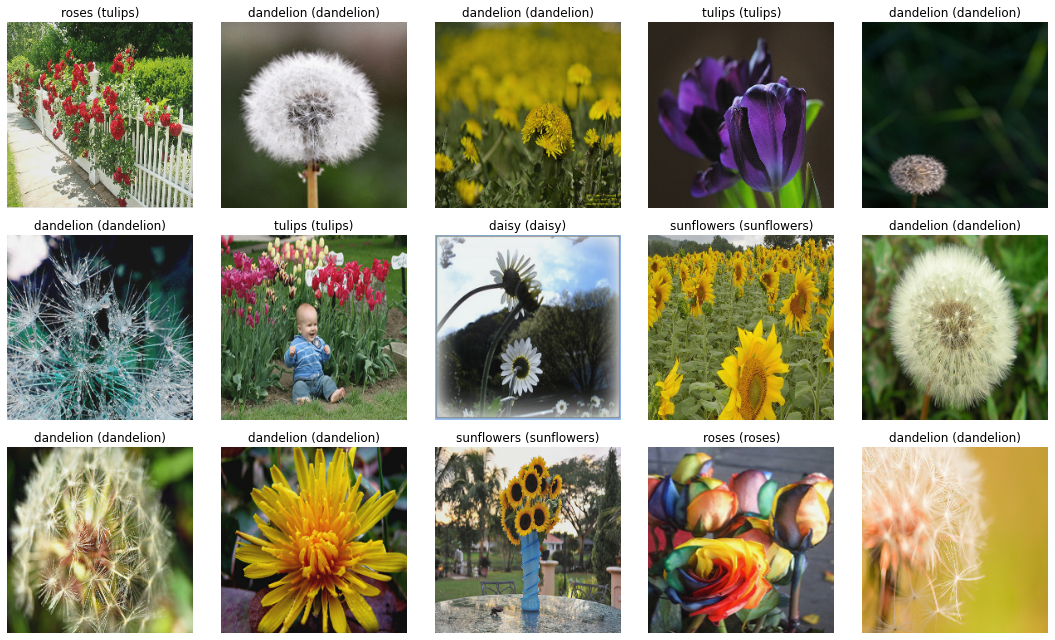

In [18]:
plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n] * STD + MEAN).numpy()
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    target = CLASSES[sample_labels[n]]
    pred = CLASSES[predictions[n]]
    plt.title("{} ({})".format(target, pred))
    plt.axis("off")
plt.tight_layout()
plt.show()


# Reference
* [ConvNeXt-TF](https://github.com/sayakpaul/ConvNeXt-TF)
* [Keras Flowers on TPU (solution)](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_solution.ipynb)